In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

the data we create is composed of three cosine functions superimposed


In [3]:
def normalizeAB(a, b, x):
    minX = x.min()
    maxX = x.max()
    return (b - a) * ((x - minX) / (maxX - minX)) + a

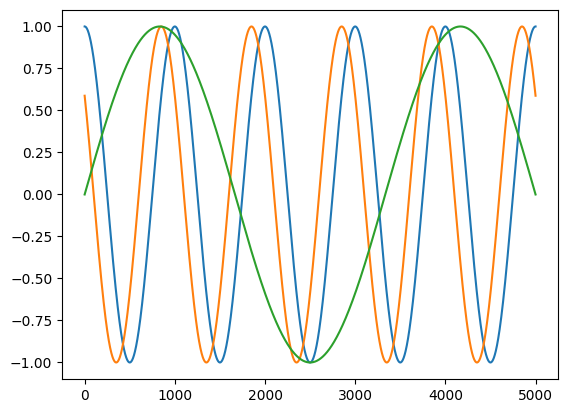

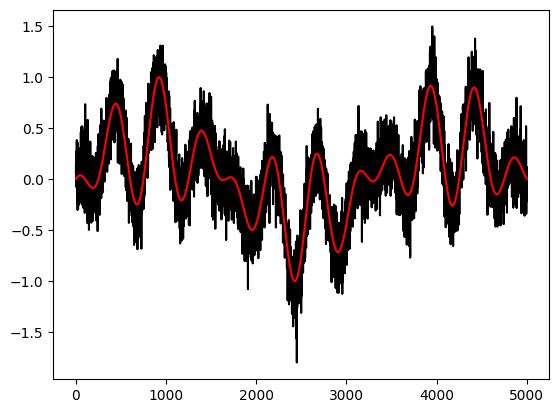

In [4]:
x = linspace(0, numpy.pi * 10, 5001)
A = numpy.cos(x)
B = numpy.cos(x + numpy.pi * 0.3)
C = numpy.cos((x + numpy.pi * 5) * 0.3)
plot(A)
plot(B)
plot(C)
figure()
rawData = normalizeAB(-1, 1, A * B * C)
noise = numpy.random.normal(0, 0.2, 5001)
data = rawData + noise
plot(data, "k")
plot(rawData, "r")

consider the first 3000 datapoints training data and the remaining 2000 test data


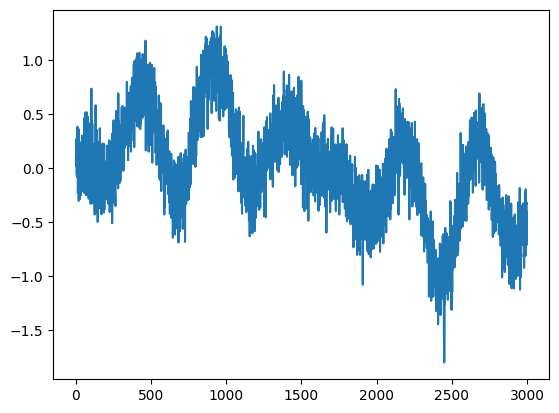

In [5]:
train_data = data[:3000]
test_data = data[3000:]

train_data, test_data
train_data_normalized = train_data
test_data_normalized = test_data
plot(train_data_normalized)

Consult code along 14 for RNN and LSTM support, implement your RNN and your LSTM


Take the "data" variable (defined above) and create four different training sets that differ in length (3,30,100,300)


In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = input_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq.flatten(), train_label))
    return inout_seq


train_window_3 = 3
train_window_30 = 30
train_window_100 = 100
train_window_300 = 300

train_inout_seq_3 = create_inout_sequences(train_data_normalized, train_window_3)
train_inout_seq_30 = create_inout_sequences(train_data_normalized, train_window_30)
train_inout_seq_100 = create_inout_sequences(train_data_normalized, train_window_100)
train_inout_seq_300 = create_inout_sequences(train_data_normalized, train_window_300)

test_inout_seq_3 = create_inout_sequences(test_data_normalized, train_window_3)
test_inout_seq_30 = create_inout_sequences(test_data_normalized, train_window_30)
test_inout_seq_100 = create_inout_sequences(test_data_normalized, train_window_100)
test_inout_seq_300 = create_inout_sequences(test_data_normalized, train_window_300)

In [10]:
print(train_inout_seq_3)
print(np.shape(train_inout_seq_300))

[(array([0.06559105, 0.15394623, 0.08791245]), array([0.01971722])), (array([0.15394623, 0.08791245, 0.01971722]), array([0.27193831])), (array([0.08791245, 0.01971722, 0.27193831]), array([0.19307434])), (array([0.01971722, 0.27193831, 0.19307434]), array([-0.06694069])), (array([ 0.27193831,  0.19307434, -0.06694069]), array([0.18402926])), (array([ 0.19307434, -0.06694069,  0.18402926]), array([0.05366679])), (array([-0.06694069,  0.18402926,  0.05366679]), array([-0.08107028])), (array([ 0.18402926,  0.05366679, -0.08107028]), array([0.38345498])), (array([ 0.05366679, -0.08107028,  0.38345498]), array([-0.00973294])), (array([-0.08107028,  0.38345498, -0.00973294]), array([0.01889129])), (array([ 0.38345498, -0.00973294,  0.01889129]), array([-0.23074414])), (array([-0.00973294,  0.01889129, -0.23074414]), array([-0.1612591])), (array([ 0.01889129, -0.23074414, -0.1612591 ]), array([0.28372359])), (array([-0.23074414, -0.1612591 ,  0.28372359]), array([-0.20731854])), (array([-0.1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2700, 2) + inhomogeneous part.

Now train an RNN on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


In [12]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        nr_of_layers_in_rnn = 1

        self.rnn = nn.RNN(
            input_size,
            self.hidden_layer_size,
            nr_of_layers_in_rnn,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, 1, self.hidden_layer_size)
        rnn_out, h0 = self.rnn(input_seq, h0)
        # print("h0", h0.shape)
        out = self.linear(rnn_out)
        return out[0][-1]


model = RNN()
print(model)
print(train_inout_seq_3[0][0], train_inout_seq_3[0][1])
sequence = torch.Tensor(train_inout_seq_3[0][0].reshape(1, train_window_3, 1))
out = model(sequence)
print()
print(sequence.shape, out.shape)

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.06559105 0.15394623 0.08791245] [0.01971722]

torch.Size([1, 3, 1]) torch.Size([1])


In [ ]:
# LSTM

In [13]:
model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epochs = 10
losses_3 = []

for i in range(epochs):
    running_loss = 0
    for seq, labels in train_inout_seq_3:
        optimizer.zero_grad()
        # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))

        # y_pred = model(seq)
        y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))

        single_loss = loss_function(y_pred, torch.Tensor(labels))
        single_loss.backward()
        optimizer.step()
        running_loss += single_loss.item()
    avg_loss = running_loss / len(train_inout_seq_3)
    losses_3.append(avg_loss)

    if i % 25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")

epoch:   1 loss: 0.03036668
epoch:   9 loss: 0.0287422910


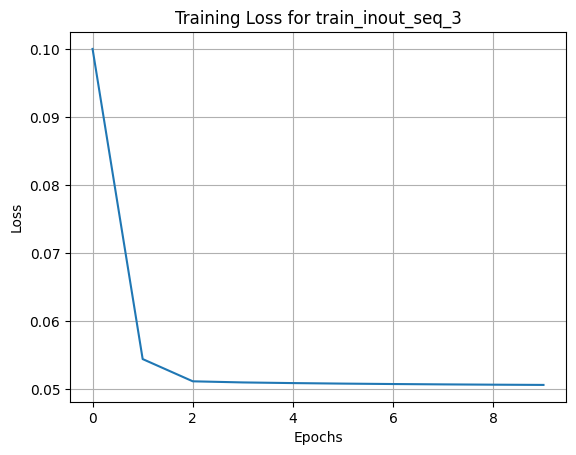

In [14]:
# Plotting the loss curve
plt.plot(range(epochs), losses_3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for train_inout_seq_3")
plt.grid(True)
plt.show()

Epoch 0 - Training Loss: 0.118341, Test Loss: 0.155845
Epoch 2 - Training Loss: 0.052114, Test Loss: 0.060003
Epoch 4 - Training Loss: 0.051377, Test Loss: 0.058470
Epoch 6 - Training Loss: 0.051025, Test Loss: 0.057729
Epoch 8 - Training Loss: 0.050803, Test Loss: 0.057207


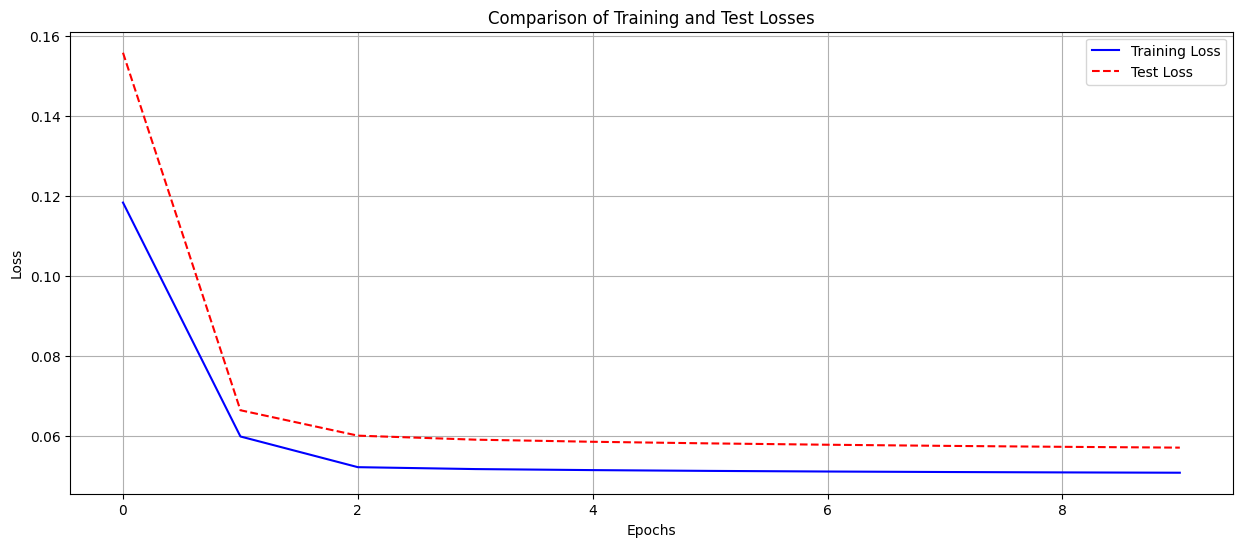

In [17]:


def train_one_epoch(model, train_data, optimizer, loss_function, train_window):
    running_loss = 0
    model.train()
    
    for seq, labels in train_data:
        optimizer.zero_grad()
        y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
        loss = loss_function(y_pred, torch.Tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss / len(train_data)

def test_one_epoch(model, test_data, loss_function, train_window):
    test_loss = 0
    model.eval()
    
    with torch.no_grad():
        for seq, labels in test_data:
            y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            test_loss += loss.item()
            
    return test_loss / len(test_data)


# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.

# Lists to store losses for each epoch
train_losses_3 = []
test_losses_3 = []

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(model, train_inout_seq_3, optimizer, loss_function, train_window_3)
    avg_test_loss = test_one_epoch(model, test_inout_seq_3, loss_function, train_window_3)
    
    train_losses_3.append(avg_train_loss)
    test_losses_3.append(avg_test_loss)
    
    if epoch % 2 == 0:  # Print every 2nd epoch for visibility
        print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_3, label="Training Loss", color="blue")
plt.plot(test_losses_3, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

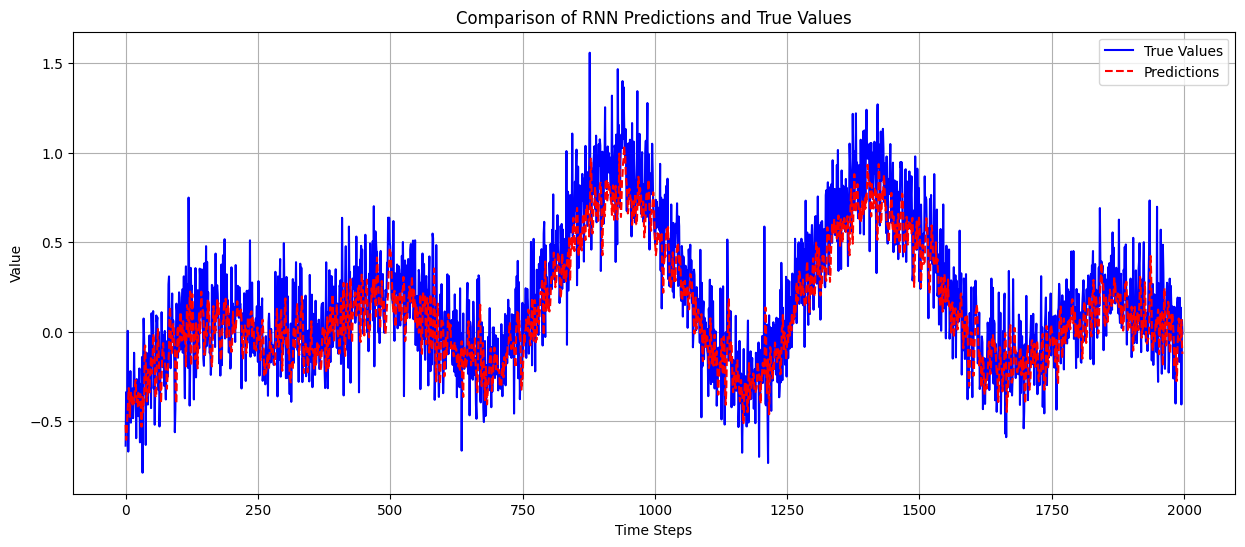

In [127]:
model.eval()
predictions = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_3:
        seq_tensor = torch.Tensor(seq.reshape(1, train_window_3, 1))
        predicted_val = model(seq_tensor)
        predictions.append(predicted_val.item())

actual_values = [label[0] for _, label in test_inout_seq_3]

plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="True Values", color="blue")
plt.plot(predictions, label="Predictions", color="red", linestyle="dashed")
plt.title("Comparison of RNN Predictions and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Epoch 0 - Training Loss: 0.090067, Test Loss: 0.072498
Epoch 1 - Training Loss: 0.044960, Test Loss: 0.055383
Epoch 2 - Training Loss: 0.044422, Test Loss: 0.052550
Epoch 3 - Training Loss: 0.044192, Test Loss: 0.051081
Epoch 4 - Training Loss: 0.044053, Test Loss: 0.050181
Epoch 5 - Training Loss: 0.043963, Test Loss: 0.049587
Epoch 6 - Training Loss: 0.043900, Test Loss: 0.049176
Epoch 7 - Training Loss: 0.043853, Test Loss: 0.048881
Epoch 8 - Training Loss: 0.043818, Test Loss: 0.048664
Epoch 9 - Training Loss: 0.043789, Test Loss: 0.048500


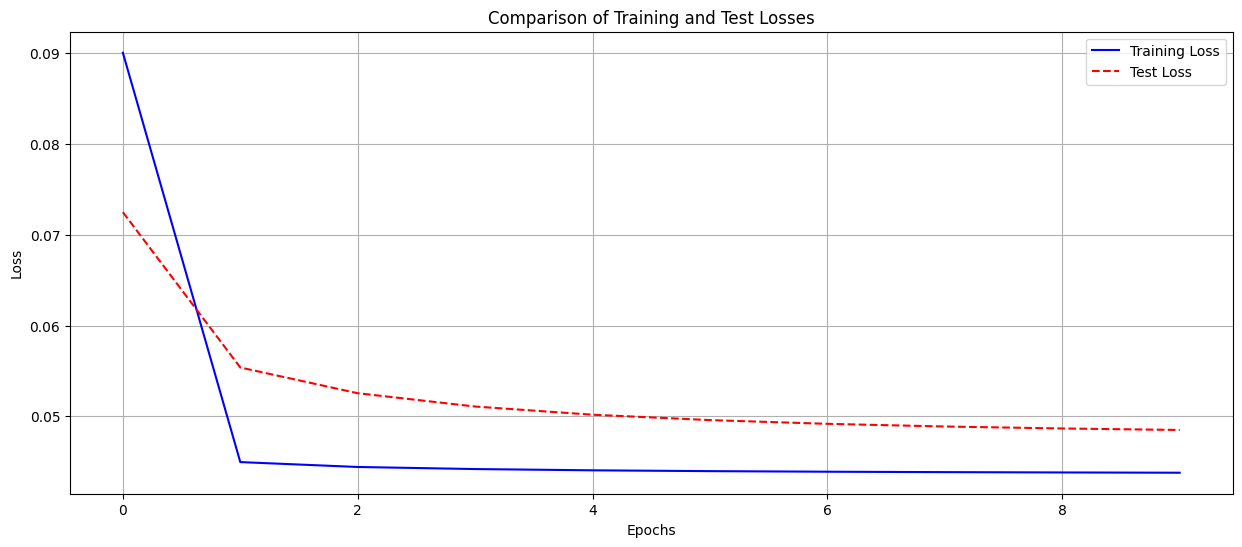

In [31]:
# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.
# Lists to store losses for each epoch
train_losses_30 = []
test_losses_30 = []

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(model, train_inout_seq_30, optimizer, loss_function, train_window_30)
    avg_test_loss = test_one_epoch(model, test_inout_seq_30, loss_function, train_window_30)
    
    train_losses_30.append(avg_train_loss)
    test_losses_30.append(avg_test_loss)
    
    # if epoch % 2 == 0:  # Print every 2nd epoch for visibility
    print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_30, label="Training Loss", color="blue")
plt.plot(test_losses_30, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0 - Training Loss: 0.238240, Test Loss: 0.201556
Epoch 1 - Training Loss: 0.217603, Test Loss: 0.180416
Epoch 2 - Training Loss: 0.195294, Test Loss: 0.158936
Epoch 3 - Training Loss: 0.168590, Test Loss: 0.134033
Epoch 4 - Training Loss: 0.132091, Test Loss: 0.099483
Epoch 5 - Training Loss: 0.080378, Test Loss: 0.055909
Epoch 6 - Training Loss: 0.048073, Test Loss: 0.044975
Epoch 7 - Training Loss: 0.045038, Test Loss: 0.044571
Epoch 8 - Training Loss: 0.044890, Test Loss: 0.044483
Epoch 9 - Training Loss: 0.044812, Test Loss: 0.044419


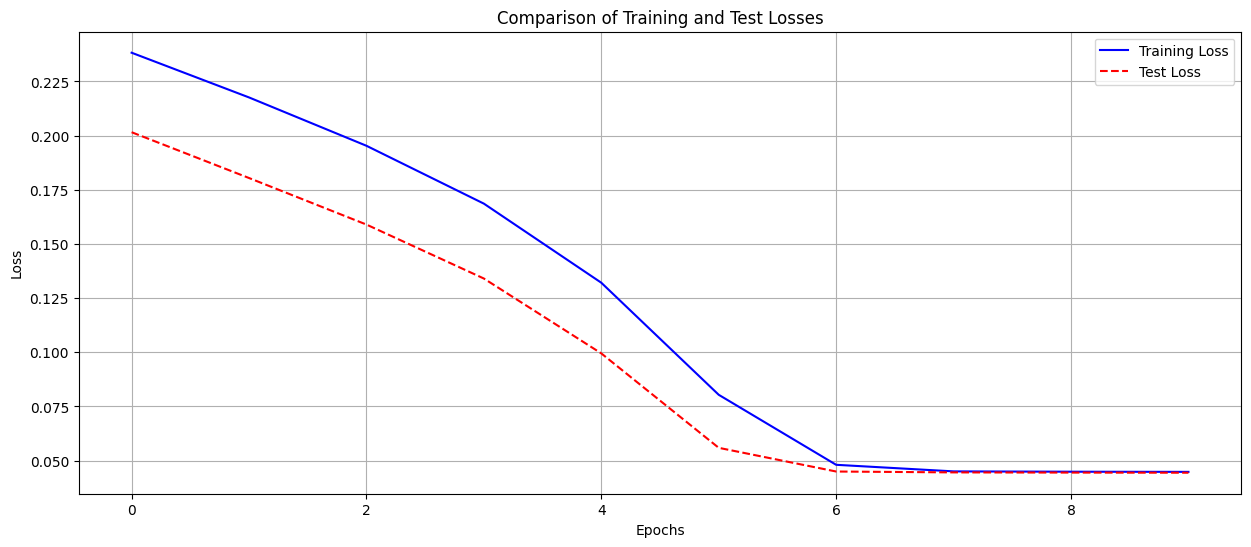

In [32]:
# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.
# Lists to store losses for each epoch
train_losses_30 = []
test_losses_30 = []

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(model, train_inout_seq_30, optimizer, loss_function, train_window_30)
    avg_test_loss = test_one_epoch(model, test_inout_seq_30, loss_function, train_window_30)
    
    train_losses_30.append(avg_train_loss)
    test_losses_30.append(avg_test_loss)
    
    # if epoch % 2 == 0:  # Print every 2nd epoch for visibility
    print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_30, label="Training Loss", color="blue")
plt.plot(test_losses_30, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0 - Training Loss: 0.116889, Test Loss: 0.090699
Epoch 1 - Training Loss: 0.046132, Test Loss: 0.061000
Epoch 2 - Training Loss: 0.044925, Test Loss: 0.056889
Epoch 3 - Training Loss: 0.044447, Test Loss: 0.054876
Epoch 4 - Training Loss: 0.044182, Test Loss: 0.053637
Epoch 5 - Training Loss: 0.044022, Test Loss: 0.052802
Epoch 6 - Training Loss: 0.043919, Test Loss: 0.052211
Epoch 7 - Training Loss: 0.043848, Test Loss: 0.051775
Epoch 8 - Training Loss: 0.043798, Test Loss: 0.051444
Epoch 9 - Training Loss: 0.043760, Test Loss: 0.051187


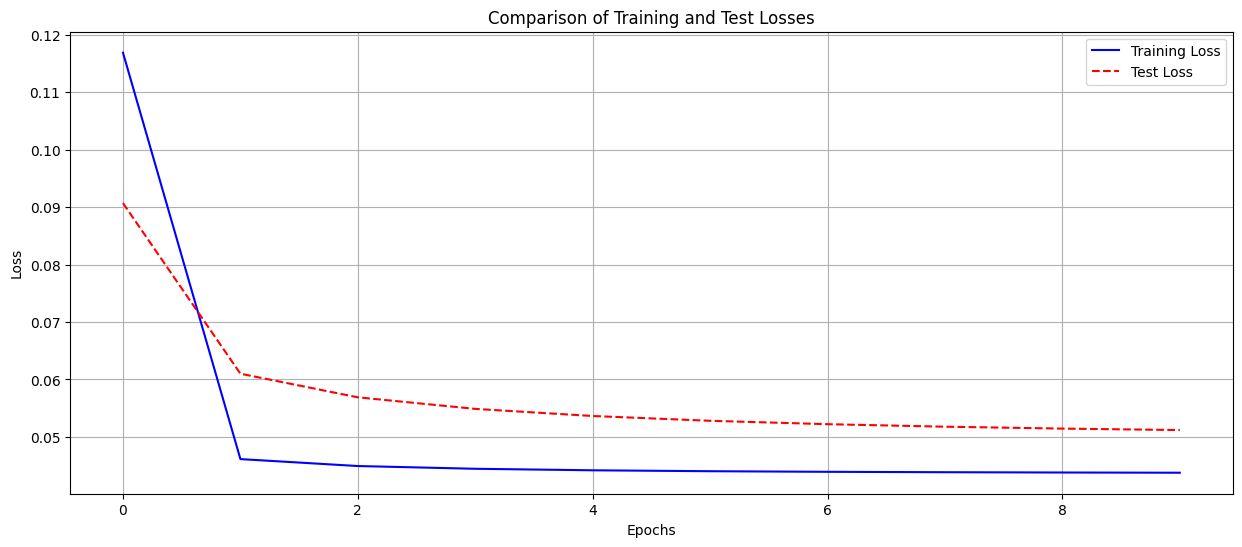

In [34]:
# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.
# Lists to store losses for each epoch
train_losses_100 = []
test_losses_100 = []

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(model, train_inout_seq_100, optimizer, loss_function, train_window_100)
    avg_test_loss = test_one_epoch(model, test_inout_seq_100, loss_function, train_window_100)
    
    train_losses_100.append(avg_train_loss)
    test_losses_100.append(avg_test_loss)
    
    # if epoch % 2 == 0:  # Print every 2nd epoch for visibility
    print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_100, label="Training Loss", color="blue")
plt.plot(test_losses_100, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0 - Training Loss: 0.102223, Test Loss: 0.058629
Epoch 1 - Training Loss: 0.043657, Test Loss: 0.052717
Epoch 2 - Training Loss: 0.043428, Test Loss: 0.051782
Epoch 3 - Training Loss: 0.043308, Test Loss: 0.051252
Epoch 4 - Training Loss: 0.043233, Test Loss: 0.050897
Epoch 5 - Training Loss: 0.043184, Test Loss: 0.050645
Epoch 6 - Training Loss: 0.043150, Test Loss: 0.050461
Epoch 7 - Training Loss: 0.043125, Test Loss: 0.050322
Epoch 8 - Training Loss: 0.043107, Test Loss: 0.050213
Epoch 9 - Training Loss: 0.043092, Test Loss: 0.050126


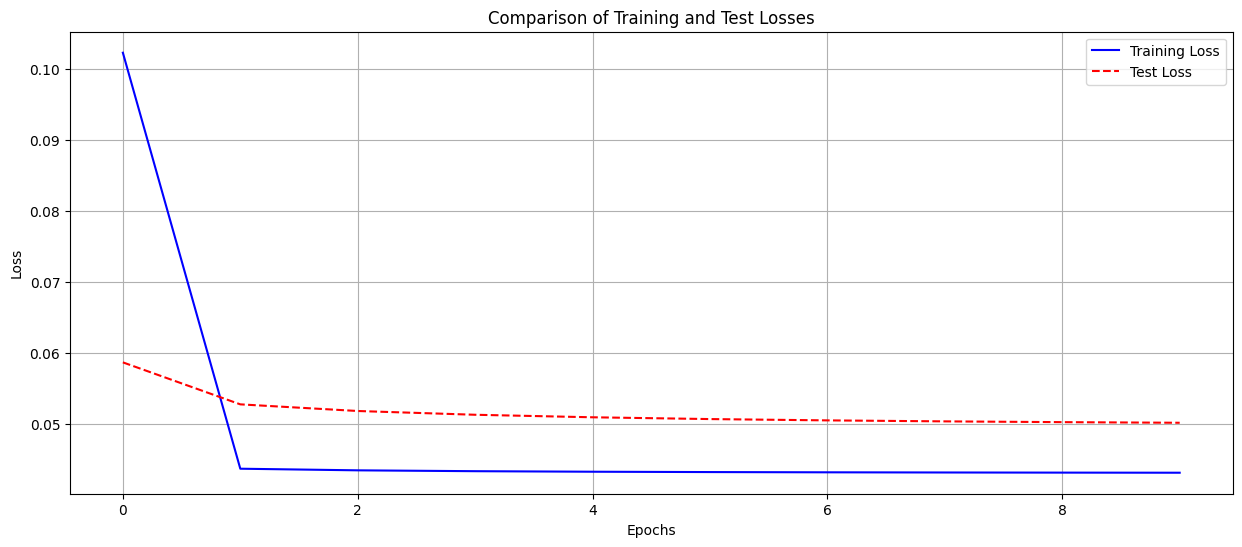

In [35]:
# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.
# Lists to store losses for each epoch
train_losses_300 = []
test_losses_300 = []

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(model, train_inout_seq_300, optimizer, loss_function, train_window_300)
    avg_test_loss = test_one_epoch(model, test_inout_seq_300, loss_function, train_window_300)
    
    train_losses_300.append(avg_train_loss)
    test_losses_300.append(avg_test_loss)
    
    # if epoch % 2 == 0:  # Print every 2nd epoch for visibility
    print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_300, label="Training Loss", color="blue")
plt.plot(test_losses_300, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Now train an LSTM on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


take that last trained RNN (for 300 datapoints) and the last LSTM, determine the next 5000 datapoints by feeding the output of the RNN (or LSTM) back into the model, plot the predictions


Which of the two models RNN or LSTM has a better prediction horizon? Write your answer as a couple of sentences, and give the reasons for your interpretation
